In [1]:
import json
from pathlib import Path

from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import pickle
import torch
from torch import nn
import numpy as np
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

from gensim.test.utils import common_texts
from gensim.models import Word2Vec
import gensim.downloader as api

import re

/users/eleves-b/2021/timothee.vincon/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def flatten(list_of_list):
    return [item for sublist in list_of_list for item in sublist]

In [3]:
path_to_training = Path("../data/training")
path_to_test = Path("../data/test")

#####
# training and test sets of transcription ids
#####
training_set = ['ES2002', 'ES2005', 'ES2006', 'ES2007', 'ES2008', 'ES2009', 'ES2010', 'ES2012', 'ES2013', 'ES2015', 'ES2016', 'IS1000', 'IS1001', 'IS1002', 'IS1003', 'IS1004', 'IS1005', 'IS1006', 'IS1007', 'TS3005', 'TS3008', 'TS3009', 'TS3010', 'TS3011', 'TS3012']
training_set = flatten([[m_id+s_id for s_id in 'abcd'] for m_id in training_set])
training_set.remove('IS1002a')
training_set.remove('IS1005d')
training_set.remove('TS3012c')

test_set = ['ES2003', 'ES2004', 'ES2011', 'ES2014', 'IS1008', 'IS1009', 'TS3003', 'TS3004', 'TS3006', 'TS3007']
test_set = flatten([[m_id+s_id for s_id in 'abcd'] for m_id in test_set])

In [4]:
model = api.load('glove-twitter-100')

In [5]:
model['hello'].shape

(100,)

In [6]:
y_training = []
with open("../data/training_labels.json", "r") as file:
    training_labels = json.load(file)
X_training = []
for transcription_id in training_set:
    with open(path_to_training / f"{transcription_id}.json", "r") as file:
        transcription = json.load(file)
    
    for utterance in transcription:
        vecs = []
        vecs.append(model[utterance["speaker"].lower()])
        for word in re.split(" |'", utterance["text"]):
            if word.lower() == "<vocalsound>":
                vecs.append(model["vocal"])
                vecs.append(model["sound"])
            elif word.lower() == "<disfmarker>":
                vecs.append(model["marker"])
            elif word.lower() == "<gap>":
                vecs.append(model["gap"])
            elif word.lower() not in model:
                pass
            else:
                vecs.append(model[word.lower()])
        while len(vecs) < 80:
            vecs.append(np.zeros(100))
        if len(vecs) > 80:
            print(len(vecs))
        X_training.append(vecs)
    
    y_training += training_labels[transcription_id]


In [7]:
X_training = np.array(X_training)
y_training = np.array(y_training)

print(X_training.shape)
print(y_training.shape)

(72623, 80, 100)
(72623,)


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

X_train, X_test, y_train, y_test = train_test_split(X_training, y_training, test_size=0.2, random_state=42)

# define batch size
batch_size = 64

# create tensor datasets
trainset = TensorDataset(torch.from_numpy(X_train).float().to(device), torch.from_numpy(y_train).float().to(device))
testset = TensorDataset(torch.from_numpy(X_test).float().to(device), torch.from_numpy(y_test).float().to(device))

# create dataloaders
train_loader = DataLoader(trainset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(testset, shuffle=True, batch_size=batch_size)

In [14]:
def train_model(model, optimizer, loss_criterion):
    iter = 0
    num_epochs = 100
    history_train_acc, history_val_acc, history_train_loss, history_val_loss = [], [], [], []
    best_f1_score = 0
    for epoch in range(num_epochs):
        for i, (samples, labels) in enumerate(train_loader):
            
            # Training mode
            model.train()

            # Load samples

            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()

            # Forward pass to get output/logits
            outputs = model(samples)

            # Calculate Loss: softmax --> cross entropy loss
            loss = loss_criterion(outputs, labels)

            # Getting gradients w.r.t. parameters
            loss.backward()

            # Updating parameters
            optimizer.step()

            iter += 1

            if iter % 1000 == 0:
                # Get training statistics
                train_loss = loss.data.item()

                # Testing mode
                model.eval()
                # Calculate Accuracy         
                correct = 0
                total = 0
                true_positives = 0
                true_negatives = 0
                false_positives = 0
                false_negatives = 0
                # Iterate through test dataset
                for samples, labels in test_loader:
                    # Load samples

                    # Forward pass only to get logits/output
                    outputs = model(samples)

                    # Val loss
                    val_loss = loss_criterion(outputs.view(-1, 1), labels.view(-1, 1))

                    predicted = outputs.ge(0.5).view(-1)

                    # Total number of labels
                    total += labels.size(0)

                    # Total correct predictions
                    correct += (predicted.type(torch.FloatTensor).cpu() == labels.type(torch.FloatTensor)).sum().item()

                    true_positives += ((predicted.type(torch.FloatTensor).cpu() == 1) & (labels.type(torch.FloatTensor) == 1)).sum().item()
                    true_negatives += ((predicted.type(torch.FloatTensor).cpu() == 0) & (labels.type(torch.FloatTensor) == 0)).sum().item()
                    false_positives += ((predicted.type(torch.FloatTensor).cpu() == 1) & (labels.type(torch.FloatTensor) == 0)).sum().item()
                    false_negatives += ((predicted.type(torch.FloatTensor).cpu() == 0) & (labels.type(torch.FloatTensor) == 1)).sum().item()


                f1_score = 2 * true_positives / (2 * true_positives + false_positives + false_negatives)

                # Print Loss
                print('Iter: {} | Train Loss: {} | Val Loss: {} | Val F1: {} | lr: {}'.format(iter, train_loss, val_loss.item(), round(f1_score, 4), optimizer.param_groups[0]['lr']))
                optimizer.param_groups[0]['lr'] *= 0.9

                # Append to history
                history_val_loss.append(val_loss.data.item())
                history_val_acc.append(round(f1_score, 4))
                history_train_loss.append(train_loss)

                # Save model when accuracy beats best accuracy
                if f1_score > best_f1_score:
                    best_f1_score = f1_score
                    # We can load this best model on the validation set later
                    torch.save(model.state_dict(), 'best_model.pth')
    return (history_train_acc, history_val_acc, history_train_loss, history_val_loss)



In [10]:
def plot_losses(history_train_loss, history_val_loss):
    # Set plotting style
    #plt.style.use(('dark_background', 'bmh'))
    plt.style.use('bmh')
    plt.rc('axes', facecolor='none')
    plt.rc('figure', figsize=(16, 4))

    # Plotting loss graph
    plt.plot(history_train_loss, label='Train')
    plt.plot(history_val_loss, label='Validation')
    plt.title('Loss Graph')
    plt.legend()
    plt.show()

In [11]:
embedding_dim = 100
hidden_dim = 128
output_dim = 1

# Loss function (binary cross-entropy)
criterion = nn.BCELoss()

In [12]:
class LSTMModel(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_class):
        """
        embed_dim: (int) size of embeddings
        hidden_dim: (int) number of hidden units
        num_class: (int) number of classes
        """
        super().__init__()
        self.hidden_dim=hidden_dim
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=1, bidirectional=False, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_class)

        #self.dropout = nn.Dropout(0.8)
        

    def forward(self, text):
        r"""
        Arguments:
            text: 1-D tensor representing a bag of text tensors
        """
        output, (hidden, cell) = self.lstm(text)
        #for the sizes:
        #output:[batch_size, sent_len, hidden_dim*num directions]
        #hidden: [num_layers * num_directions, batch_size, hidden_dim]
        x = hidden.view(-1, self.hidden_dim)
        
        #x=self.dropout(x)
        x=self.fc(x)
        out = torch.sigmoid(x)
        return out.squeeze(1)

Iter: 1000 | Train Loss: 0.4367656707763672 | Val Loss: 0.25724321603775024 | Val F1: 0.0008 | lr: 0.001
Iter: 2000 | Train Loss: 0.3876723647117615 | Val Loss: 0.39260730147361755 | Val F1: 0.3939 | lr: 0.0009000000000000001
Iter: 3000 | Train Loss: 0.33613112568855286 | Val Loss: 0.22476345300674438 | Val F1: 0.3783 | lr: 0.0008100000000000001
Iter: 4000 | Train Loss: 0.2867249846458435 | Val Loss: 0.20318545401096344 | Val F1: 0.5439 | lr: 0.000729
Iter: 5000 | Train Loss: 0.3371202349662781 | Val Loss: 0.48305484652519226 | Val F1: 0.4637 | lr: 0.0006561000000000001
Iter: 6000 | Train Loss: 0.28461766242980957 | Val Loss: 0.3091719448566437 | Val F1: 0.3882 | lr: 0.00059049
Iter: 7000 | Train Loss: 0.2291782796382904 | Val Loss: 0.3746318221092224 | Val F1: 0.4706 | lr: 0.000531441
Iter: 8000 | Train Loss: 0.2582944631576538 | Val Loss: 0.2925061583518982 | Val F1: 0.5361 | lr: 0.0004782969
Iter: 9000 | Train Loss: 0.235012948513031 | Val Loss: 0.4484313130378723 | Val F1: 0.5101 |

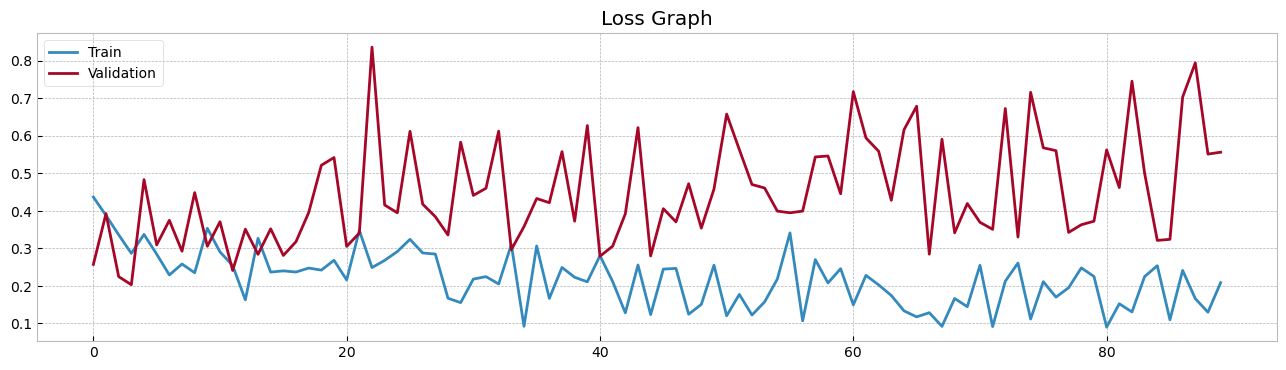

In [15]:
lstm = LSTMModel(embedding_dim, hidden_dim, output_dim)
lstm.to(device)

# Optimizer
optimizer = torch.optim.RMSprop(lstm.parameters(), lr=1e-3) #not necessary if the order is respected


(train_acc, val_acc, train_loss, val_loss) = train_model(lstm, optimizer, criterion)
plot_losses(train_loss, val_loss)